# Analysis of "Experiments on Emotional Inattention---Pilot 3"


In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast
import math

def load_csv_files(subfolder_name):
    notebook_path = os.path.dirname(os.path.abspath('__file__'))
    data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

    all_dataframes = []
    
    # Get a list of all files in the subfolder
    files = os.listdir(data_folder_path)

    # Loop through each file and load it as a pandas DataFrame
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(data_folder_path, file)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all DataFrames into one, stacking them on top of each other
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

# Usage:
subfolder_name = '2023-09-pilot3'
data = load_csv_files(subfolder_name)

# Remove duplicates based on all columns
data.drop_duplicates(inplace=True)
# data.drop_duplicates(inplace=True,subset=['participant.label'])


# restrict to sessions:
def restrict_to_sessions(data, session_codes):
    return data[data['session.code'].isin(session_codes)]

session_codes = []
if session_codes != []:
    data = restrict_to_sessions(data, session_codes)

data.rename(columns={'pilot3.1.player.wtp': 'wtp_MPL'},inplace=True)

data.drop(columns=['participant.feedback','pilot3.1.player.payoff'], inplace=True)

# Drop all columns that do not begin with 'participant'
# data = data.filter(regex='^participant.')

data.columns = data.columns.str.replace('participant.', '')
data.columns = data.columns.str.replace('pilot3.1.player.', '')

# List of pages to check against
pages_to_exclude = ['Welcome', 'Consent']

# Create a new column 'not_in_list' based on the condition
data['started_experiment'] = data['_current_page_name'].apply(lambda x: x not in pages_to_exclude and pd.notna(x))

# # Create a new column 'finished_experiment' based on the condition
# data['finished_experiment'] = data['_current_page_name'].apply(lambda x: x == 'Finished')


# Calculate the number of rows with 'finished_experiment' equal to True for each treatment
finished_experiment_count = data[data['finished'] == True].groupby('treatment').size()

# Calculate the number of rows with 'started_experiment' equal to True for each treatment
started_experiment_count = data[data['started_experiment'] == True].groupby('treatment').size()

# Calculate the ratio for each treatment
ratio_by_treatment = finished_experiment_count / started_experiment_count

print('Attrition by treatment: ',ratio_by_treatment)

print('Starters: ', started_experiment_count)

print('Finishers: ', finished_experiment_count)

# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished'] == True]



# Convert the JSON strings to dictionaries
# Function to parse JSON strings while handling NaN values
def parse_dict_string(dict_string):
    # Check if the input is a string
    if not isinstance(dict_string, str):
        return np.NaN
    
    # Replace single quotes with double quotes before parsing as JSON
    corrected_dict_string = dict_string.replace("'", "\"")
    try:
        return json.loads(corrected_dict_string)
    except json.JSONDecodeError:
        return np.NaN

# Convert the JSON strings to dictionaries, handling NaN values
for column in ['times','mistakes']:
    data[column] = data[column].apply(parse_dict_string)

# Custom function to calculate the total from the 'mistakes' dictionary
def calculate_mistakes_total(mistakes_dict):
    # Check if the value is a dictionary
    if isinstance(mistakes_dict, dict):
        # Extract the values from the dictionary and sum them
        total = sum(mistakes_dict.values())
        return total
    else:
        return None

# Apply the custom function to create the new column 'mistakes_total'
data['mistakes_total'] = data['mistakes'].apply(calculate_mistakes_total)

data = pd.concat([data,
                 data['times'].apply(pd.Series)
                 ], axis=1)

# Custom converter function to convert array strings to actual arrays
def parse_array_string(array_string):
    try:
        return ast.literal_eval(array_string)
    except (SyntaxError, ValueError):
        return np.NaN
    
data['experiment_sequence'] = data['experiment_sequence'].apply(parse_array_string)

data['sequence'] = data['sequence'].apply(parse_array_string)

data['wtp_MPL'] = data['wtp_MPL'].apply(parse_array_string)

data['actual_data'] = data['actual_data'].apply(parse_array_string)

# Function to calculate maximum of first N elements in a list
def max_first_n(lst, n):
    return max(lst[:n])

# # Calculate the time difference and create a new column 'task_duration'
# data['task_duration'] = data['end_task'] - data['start_task']

# Calculate the time difference and create a new column 'task_duration'
data['study_duration'] = data['time_finished'] - data['time_started']
data['study_duration_minutes'] = data['study_duration'] / 60
data['study_duration_minutes'] = data['study_duration_minutes'].round(1)

all_questions = [
    'CQ_bonus_box',
    'CQ_bonus_initial',
    'CQ_bonus_time',
    'CQ_bonus_decide',
    'CQ_bonus_num_boxes',
    'CQ_bonus_stop',
    'CQ_bonus_complete',
    'CQ_penalty_box',
    'CQ_penalty_initial',
    'CQ_penalty_time',
    'CQ_penalty_decide',
    'CQ_penalty_num_boxes',
    'CQ_penalty_stop',
    'CQ_penalty_complete',
    'CQ_bonus_forced_difference',
    'CQ_penalty_forced_difference'
    ]

for question in all_questions:
    new_data = []
    for el in data['mistakes']:
        if question in el:
            new_data.append(el[question])
        else:
            new_data.append(np.nan)
    data[question] = new_data

# Select only the desired columns
selected_columns = ['label',  'feedback', 'feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay', 'treatment', 'payoff', 'study_duration_minutes']
selected_data = data[selected_columns]

# Create the 'output' folder if it doesn't exist
output_folder = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create the 'subfolder' inside the 'output' folder if it doesn't exist
subfolder_path = os.path.join(output_folder, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'feedback.csv')
selected_data.to_csv(file_path, index=False)

# Select only the desired columns
selected_columns = ['label',  'confused_binary', 'confused_text']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'confused.csv')
selected_data.to_csv(file_path, index=False)


# Custom function to calculate the WTP
def calculate_wtp(dictionary_list):
    d = dictionary_list[-1]


    task_keys = [float(key) for key, value in d.items() if value == 'task']
    sure_keys = [float(key) for key, value in d.items() if value == 'sure']

    
    if 'task' not in d.values():
        return min(sure_keys) - 5
    
    if 'sure' not in d.values():
        return max(task_keys) + 5
    
    lowest_sure_key = min(sure_keys)
    
    highest_task_key = max(task_keys)

    if lowest_sure_key < highest_task_key:
        return np.nan
    
    return (lowest_sure_key + highest_task_key) / 2
    
# Create a new column 'new_column' based on the custom function
data['wtp_point'] = data['wtp_MPL'].apply(calculate_wtp)
data['single_switching'] = data['wtp_point'].apply(lambda x: not pd.isna(x))


data['num_draws'] = data['actual_data'].apply(lambda x: x['num_draws'])



data['emotionsPart1'] = np.where(data['emotionsPart1_bonus'].notna(), data['emotionsPart1_bonus'], data['emotionsPart1_penalty'])





Attrition by treatment:  treatment
('tasks', 'bonus', 'low', 'original')      1.0
('tasks', 'bonus', 'low', 'reversed')      1.0
('tasks', 'penalty', 'low', 'original')    0.8
('tasks', 'penalty', 'low', 'reversed')    1.0
dtype: float64
Starters:  treatment
('tasks', 'bonus', 'low', 'original')      5
('tasks', 'bonus', 'low', 'reversed')      5
('tasks', 'penalty', 'low', 'original')    5
('tasks', 'penalty', 'low', 'reversed')    5
dtype: int64
Finishers:  treatment
('tasks', 'bonus', 'low', 'original')      5
('tasks', 'bonus', 'low', 'reversed')      5
('tasks', 'penalty', 'low', 'original')    4
('tasks', 'penalty', 'low', 'reversed')    5
dtype: int64


In [82]:


def get_element_at_index(row):
    achieved_max_bonus = True
    if row['num_draws']>0:
        sequence = json.loads(row['sequence'][row['valence']])[:int(row['num_draws'])]
        if float(max(sequence)) == float(row['actual_data']['tentative_bonus']):
            achieved_max_bonus = True
        else:
            achieved_max_bonus = False
    return achieved_max_bonus
# Create a new column 'new_column' based on the custom function
data['max_bonus_possible'] = data.apply(get_element_at_index, axis=1)


def get_sequence(row):
    
   return json.loads(row['sequence'][row['valence']])[:int(row['num_draws'])]
# Create a new column 'new_column' based on the custom function
data['actual_sequence'] = data.apply(get_sequence, axis=1)

def get_max_element_so_far(row):
    
    max_so_far = 2
    max_values = []
    for num in row['actual_sequence']:
        max_so_far = max(max_so_far, float(num))  # Update the maximum so far
        max_values.append(max_so_far) 

    max_values = max_values[:int(row['num_draws'])]
    return max_values


    
#    return json.loads(row['sequence'][row['valence']])[:int(row['num_draws'])]
# Create a new column 'new_column' based on the custom function
data['max_element_so_far'] = data.apply(get_max_element_so_far, axis=1)


def list_of_optimal_choice(row):
    optimal_choice = []
    
    sequence = json.loads(row['sequence'][row['valence']])

    tentative_bonus_sequence = row['actual_data']['tentative_bonus_sequence']

    if len(tentative_bonus_sequence)==0:
        return optimal_choice
    
    for i in range(len(tentative_bonus_sequence)):
        if i==0:
            if float(sequence[i]) > float(tentative_bonus_sequence[i]):
                optimal_choice.append(False)
            else:
                optimal_choice.append(True)

        else:
            if float(sequence[i]) > float(tentative_bonus_sequence[i]) or (float(tentative_bonus_sequence[i-1])>float(tentative_bonus_sequence[i])):
                optimal_choice.append(False)
            else:
                optimal_choice.append(True)


    return optimal_choice
# Create a new column 'new_column' based on the custom function
data['optimal_choice'] = data.apply(list_of_optimal_choice, axis=1)

data['optimal_choice']


data['share_optimal_choice'] = data['optimal_choice'].apply(lambda x: sum(x)/len(x))

# Custom function to check if all Booleans in a list are True
def check_all_true(bool_list):
    return all(bool_list)

# Create a new column 'new_column' based on the custom function
data['optimal_choice_everywhere'] = data['optimal_choice'].apply(check_all_true)

data[['actual_sequence','max_element_so_far']]



,actual_sequence,max_element_so_far
0,"[4.09, 2.38, 3.48, 3.11, 2.10, 2.06]","[4.09, 4.09, 4.09, 4.09, 4.09, 4.09]"
1,"[2.91, 2.17, 2.18, 2.97, 2.86, 2.10, 2.04, 2.4...","[2.91, 2.91, 2.91, 2.97, 2.97, 2.97, 2.97, 2.9..."
2,"[2.30, 2.18, 2.24, 2.17, 2.63, 2.22, 2.15, 2.0...","[2.3, 2.3, 2.3, 2.3, 2.63, 2.63, 2.63, 2.63, 2..."
3,"[2.63, 2.15, 2.06, 2.02, 2.52, 2.18, 2.30, 2.4...","[2.63, 2.63, 2.63, 2.63, 2.63, 2.63, 2.63, 2.6..."
4,"[2.46, 2.03, 4.52, 2.06, 2.50]","[2.46, 2.46, 4.52, 4.52, 4.52]"
5,"[2.75, 2.03, 3.34]","[2.75, 2.75, 3.34]"
7,"[2.47, 2.19, 2.20, 2.57, 2.79, 2.25, 2.44, 2.1...","[2.47, 2.47, 2.47, 2.57, 2.79, 2.79, 2.79, 2.7..."
8,"[2.90, 2.32, 2.28, 2.07, 2.85, 2.21, 2.45, 2.2...","[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 3.0, ..."
9,"[2.36, 3.29, 2.81, 3.53, 2.14, 2.50, 2.05, 2.3...","[2.36, 3.29, 3.29, 3.53, 3.53, 3.53, 3.53, 3.5..."
10,"[2.24, 2.56, 2.24, 2.16, 2.05, 2.27, 2.97, 2.2...","[2.24, 2.56, 2.56, 2.56, 2.56, 2.56, 2.97, 2.9..."


In [45]:
# Step 1: Create a list of strings in the required format
rows_as_text = [f"{label},{round(bonus_payment, 2)}" for label, bonus_payment in zip(data['label'], data['bonus_payment'])]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'bonus_payment.txt')



# Step 2: Write the strings to a text file
with open(file_path, 'w') as file:
    file.write("\n".join(rows_as_text))



file_path = os.path.join(subfolder_path, 'approved.txt')



# Step 1: Create a list of strings in the required format
rows_as_text = [f"{label}" for label in data['label']]

# Step 2: Write the strings to a text file
with open(file_path, 'w') as file:
    file.write("\n".join(rows_as_text))







In [67]:


data[['emotionsPart1','emotionsPart1_bonus','emotionsPart1_penalty']]   

,emotionsPart1,emotionsPart1_bonus,emotionsPart1_penalty
0,10.0,10.0,NaN
1,4.0,4.0,NaN
2,8.0,NaN,8.0
3,1.0,NaN,1.0
4,3.0,3.0,NaN
5,6.0,6.0,NaN
7,8.0,NaN,8.0
8,9.0,9.0,NaN
9,10.0,10.0,NaN
10,1.0,NaN,1.0


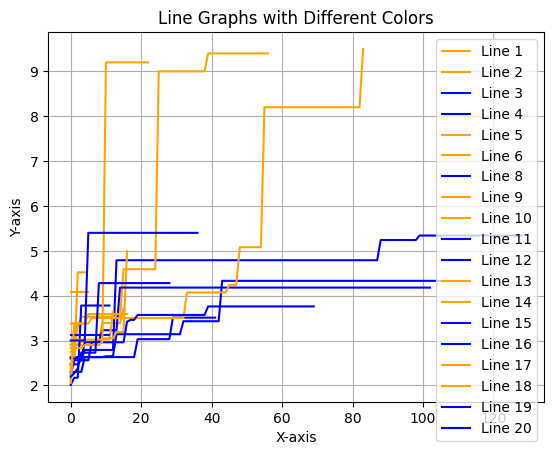

In [84]:
def plot_and_save_line_graphs(data, column_name_values, column_name_colors, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    colors_dict = {
        'bonus': 'blue',
        'penalty': 'orange'
    }
    # Iterate through rows of the DataFrame
    for index, row in data.iterrows():
        values = row[column_name_values]
        colors = row[column_name_colors]

        # Create x values based on the length of the list
        x = np.arange(len(values))

        
        # Plot the line graph with the specified color
        ax.plot(x, values, label=f'Line {index + 1}', color=colors_dict[colors])

    # Set labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Graphs with Different Colors')
    ax.legend()

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'line_graphs_{subfolder_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Usage:
column_name_values = 'max_element_so_far'
column_name_colors = 'valence'

plot_and_save_line_graphs(data, column_name_values, column_name_colors, subfolder_name)


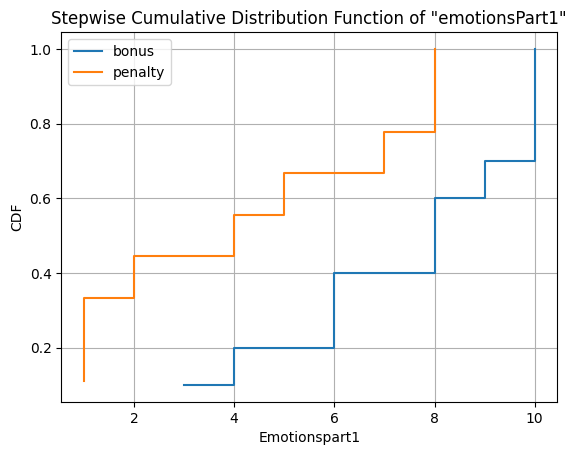

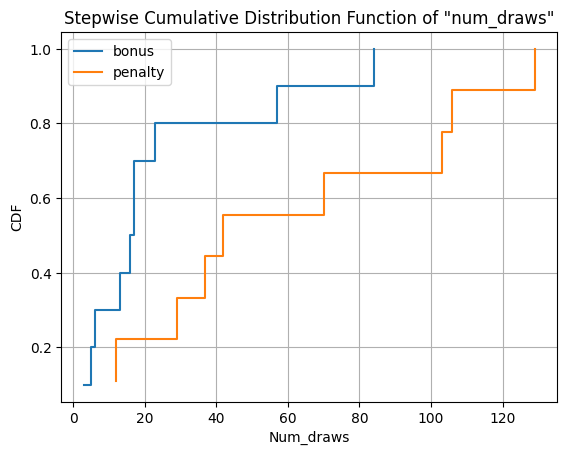

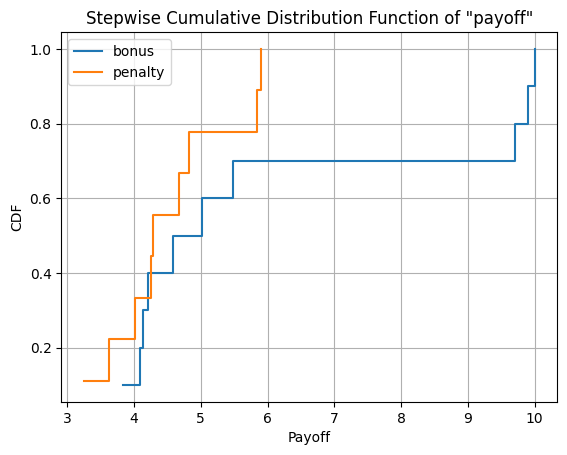

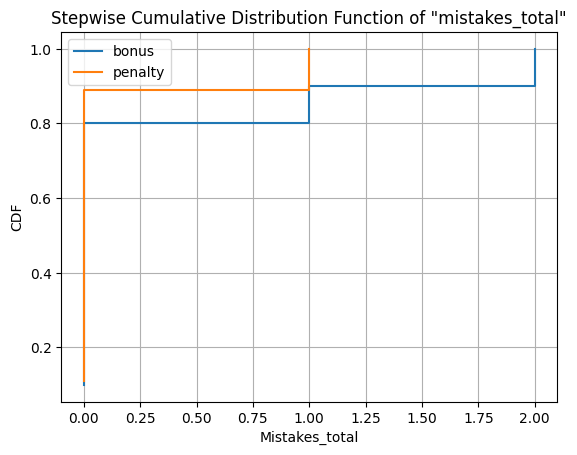

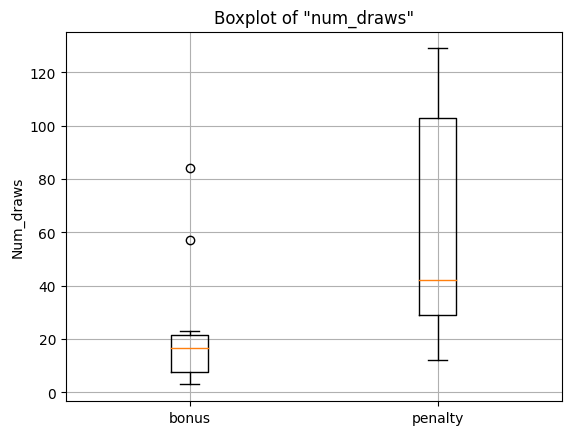

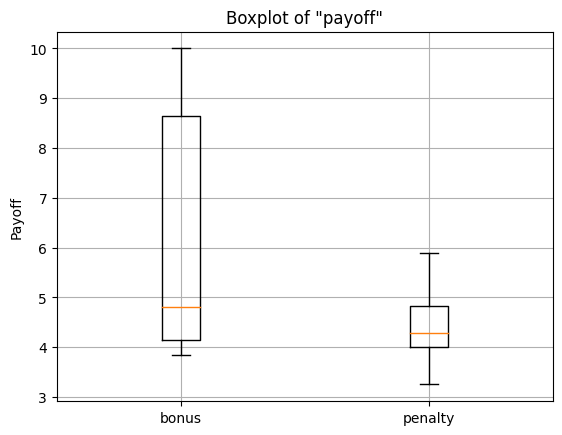

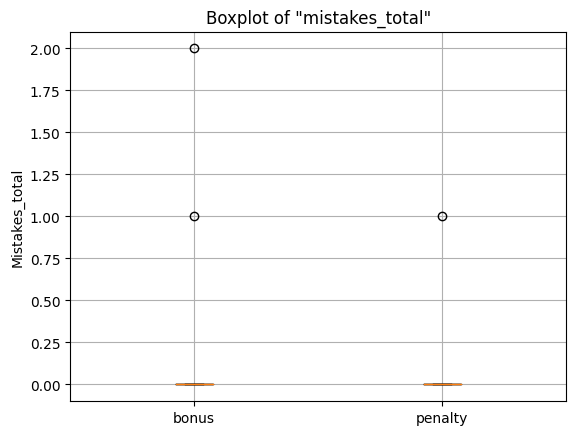

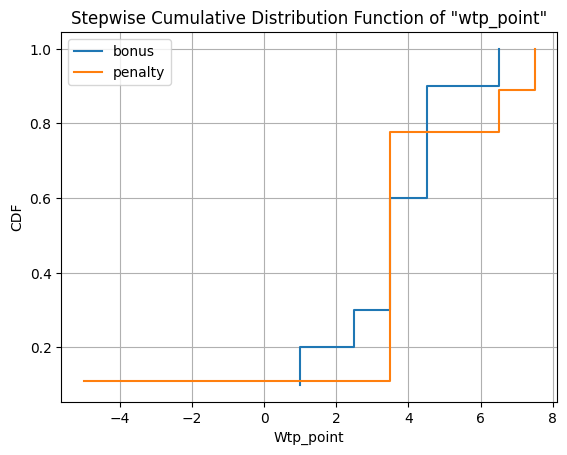

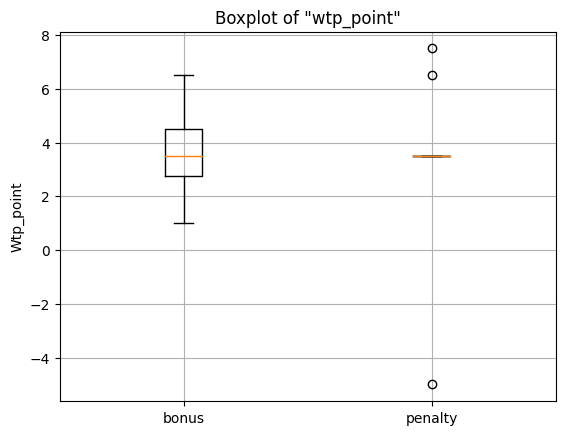

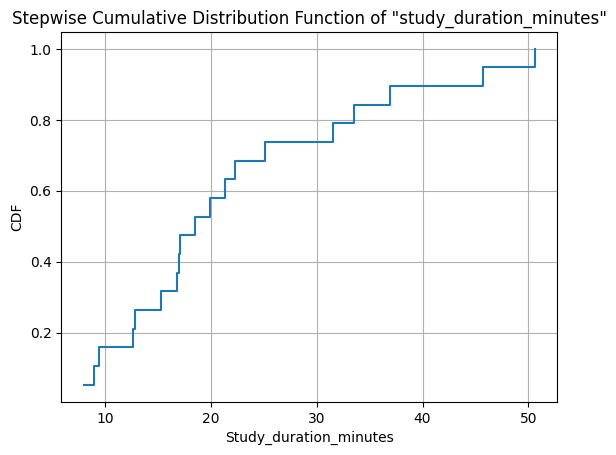

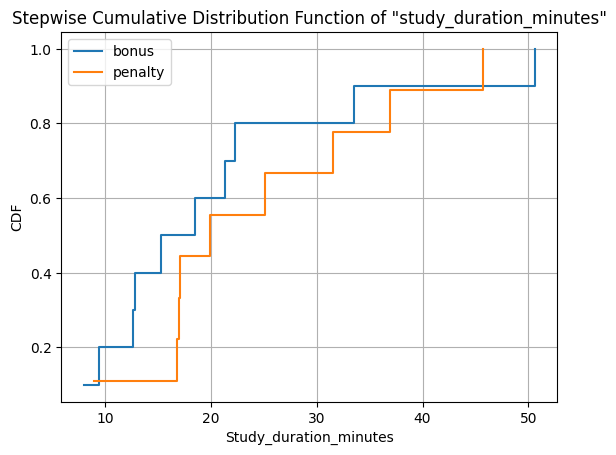

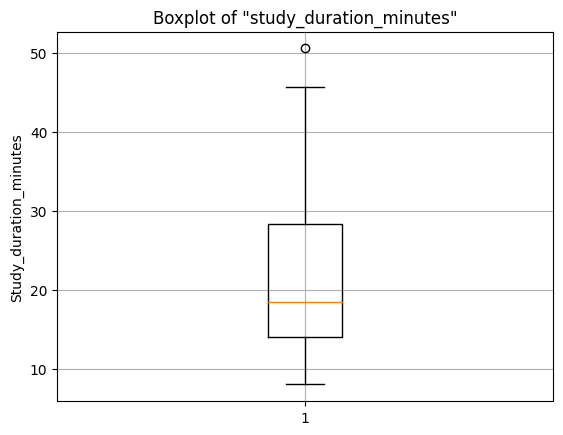

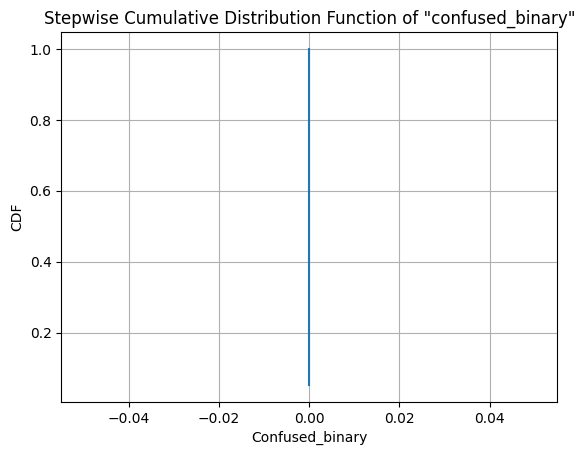

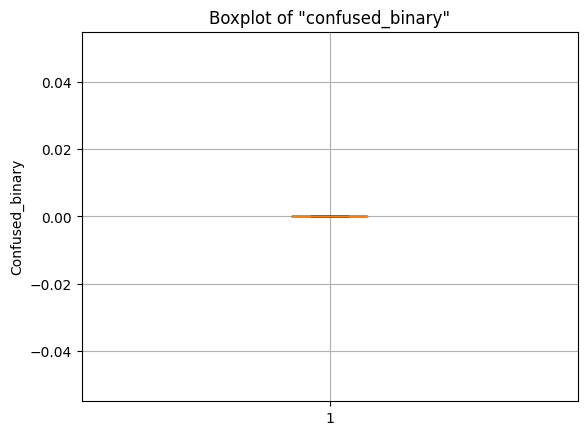

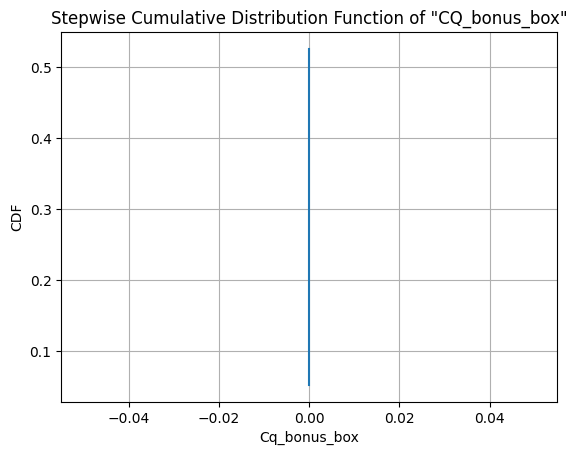

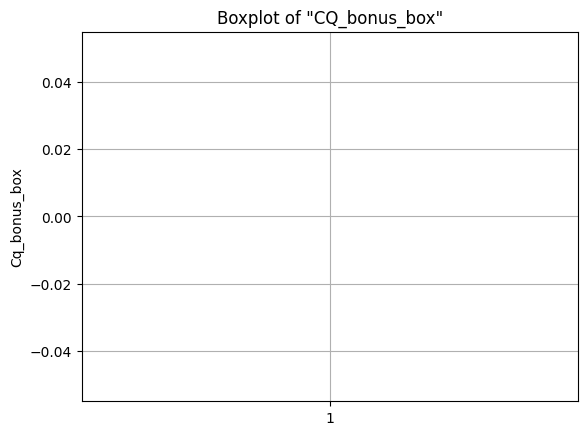

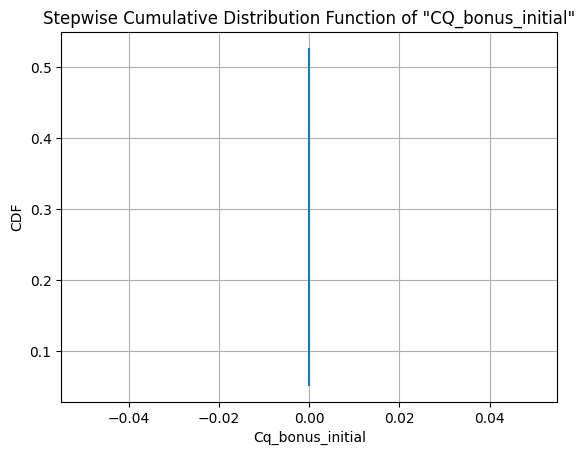

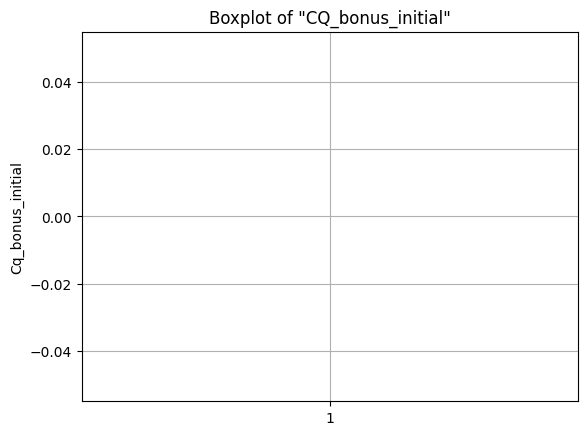

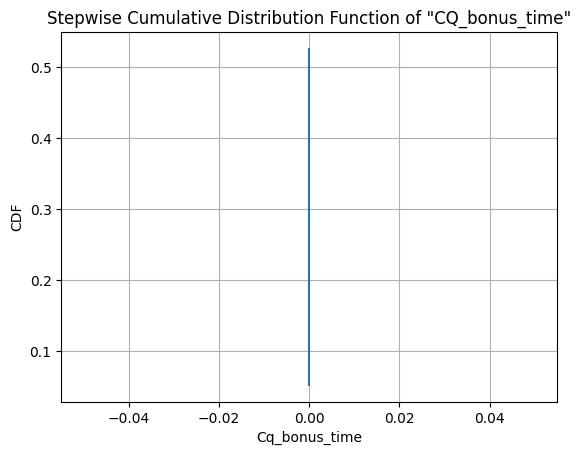

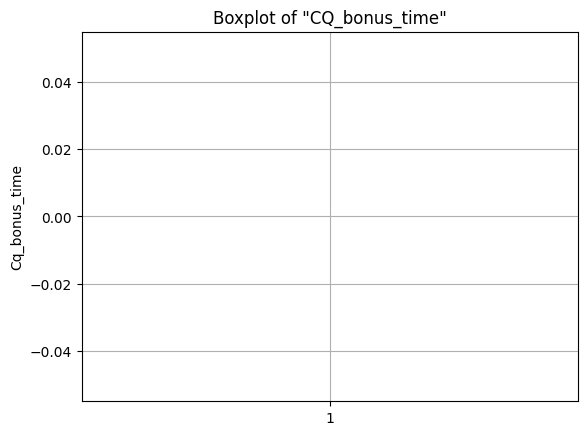

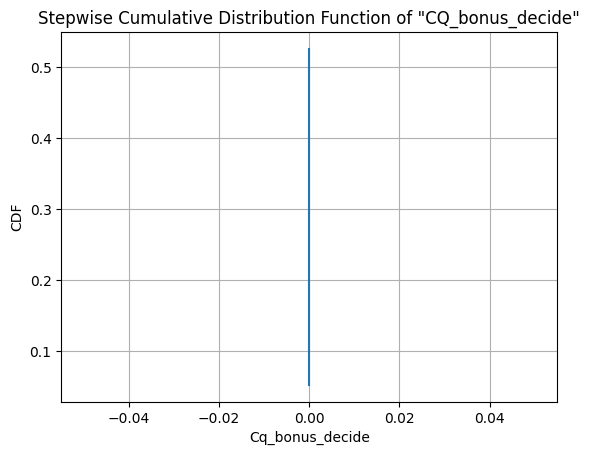

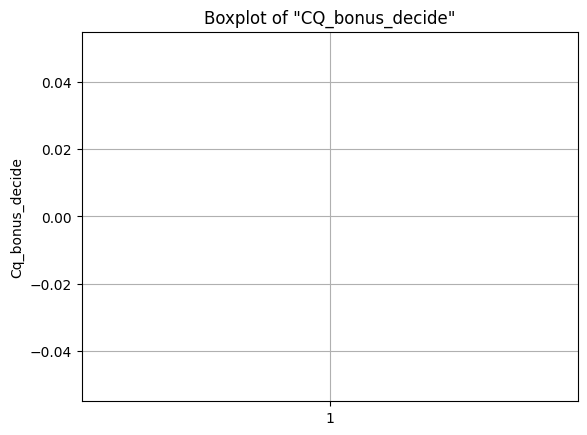

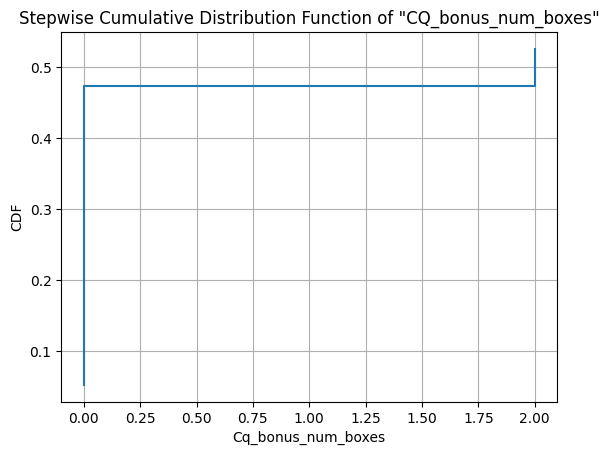

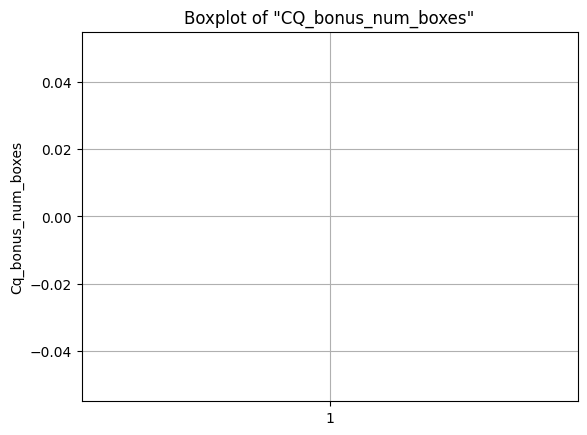

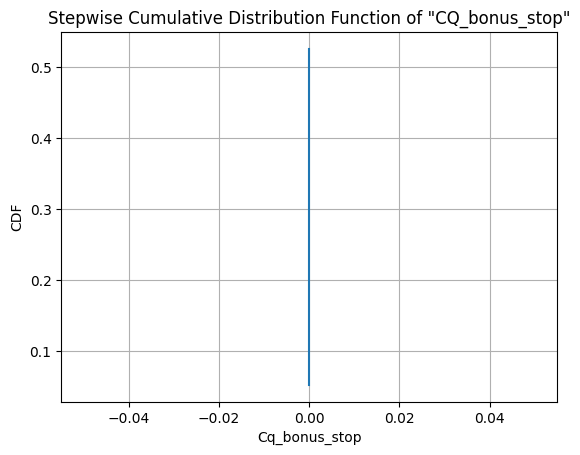

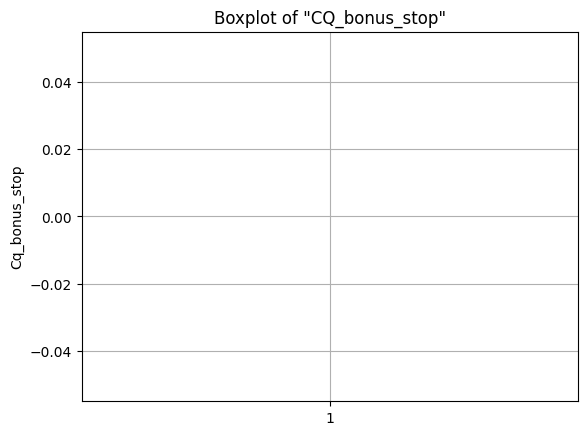

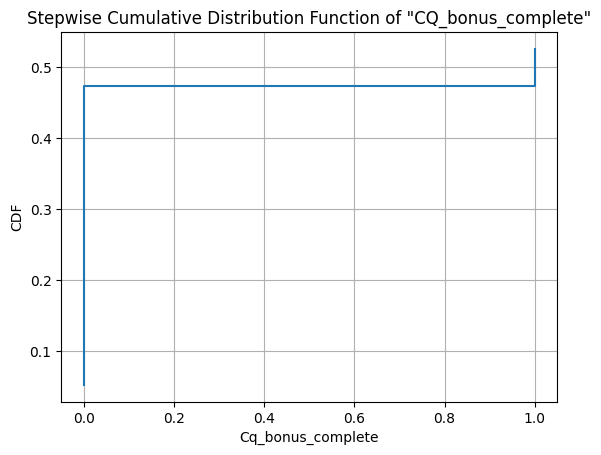

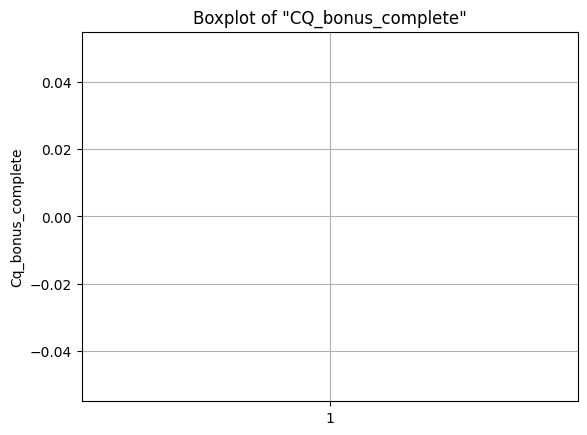

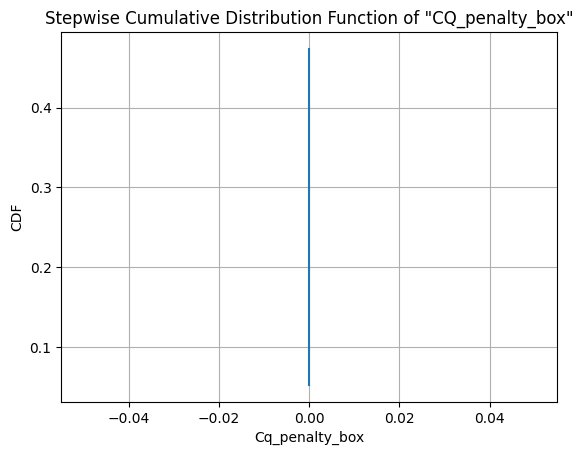

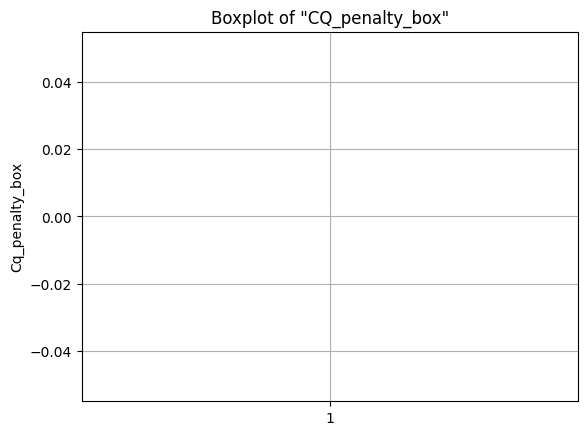

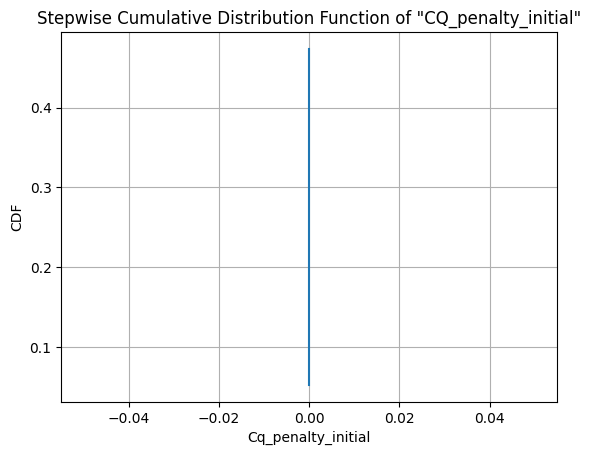

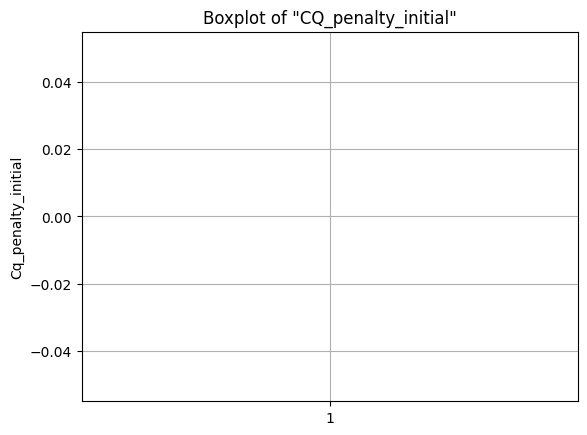

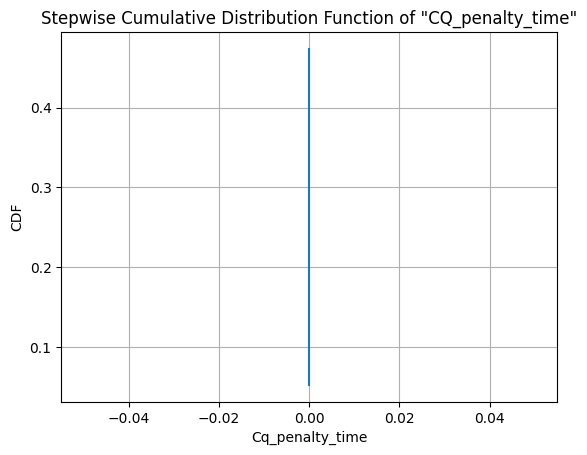

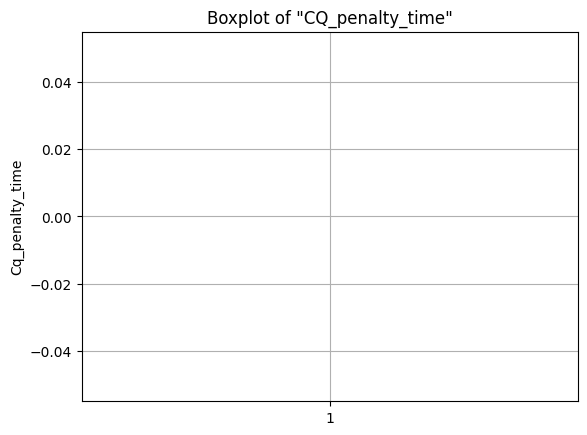

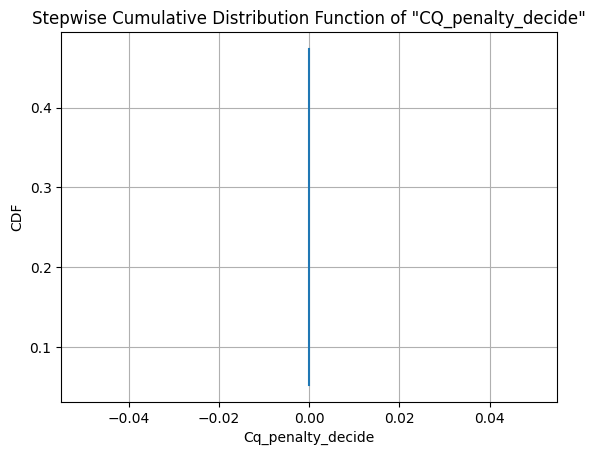

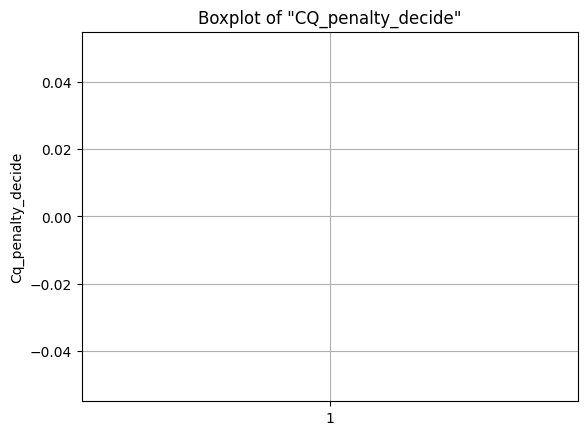

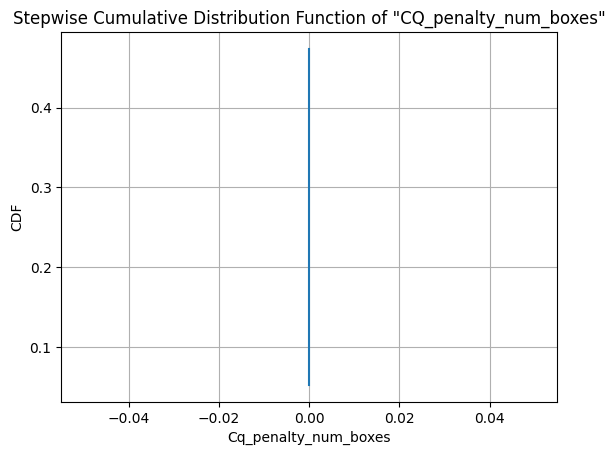

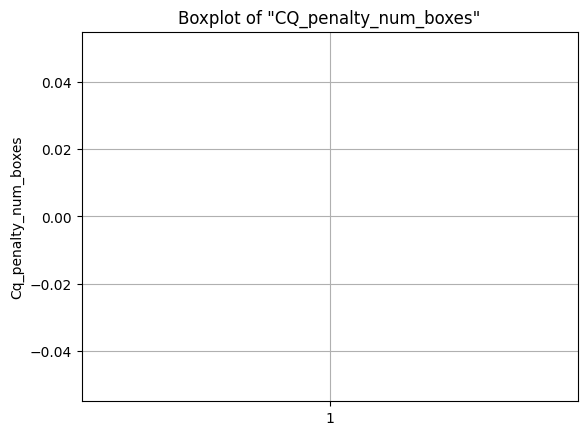

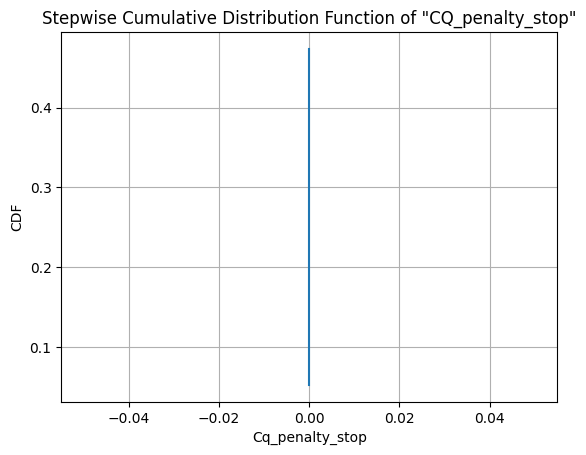

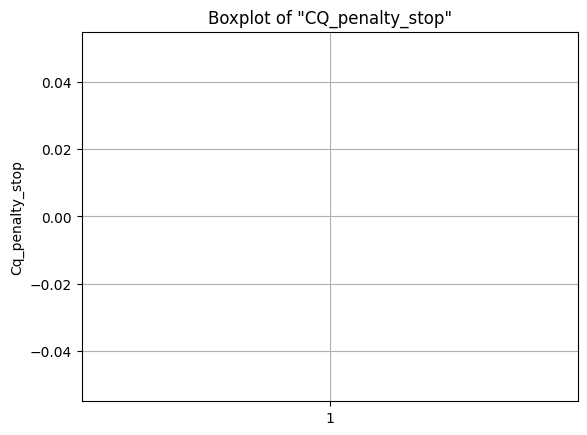

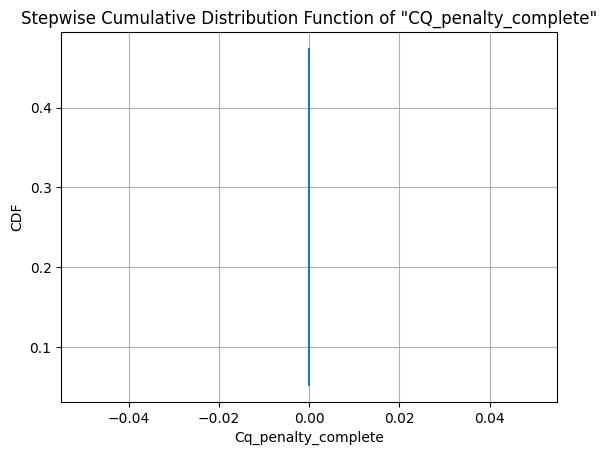

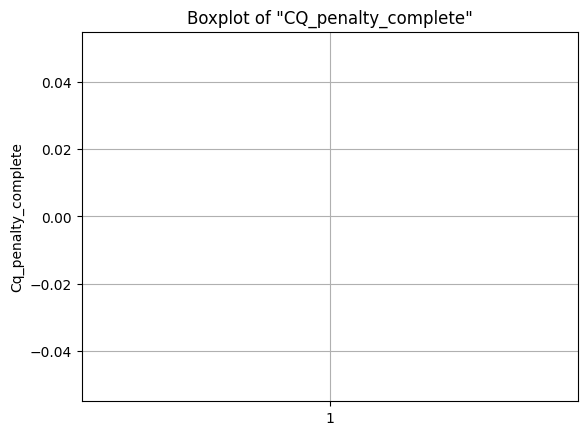

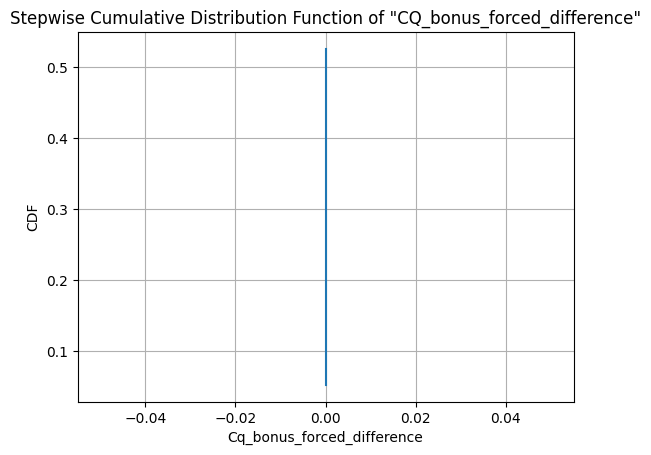

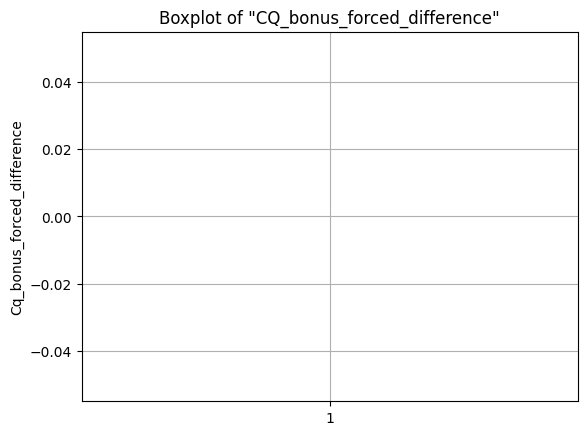

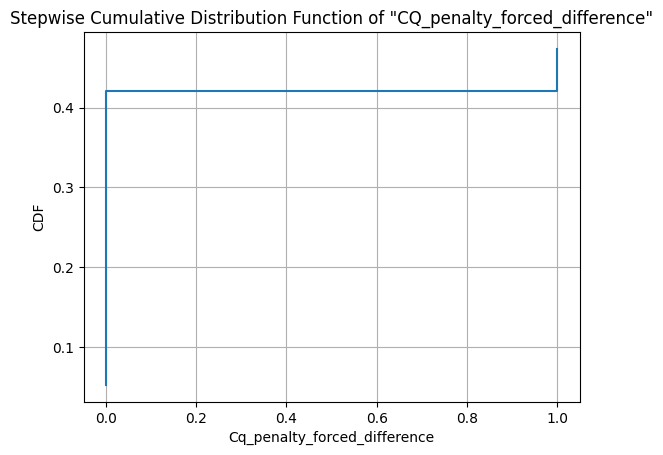

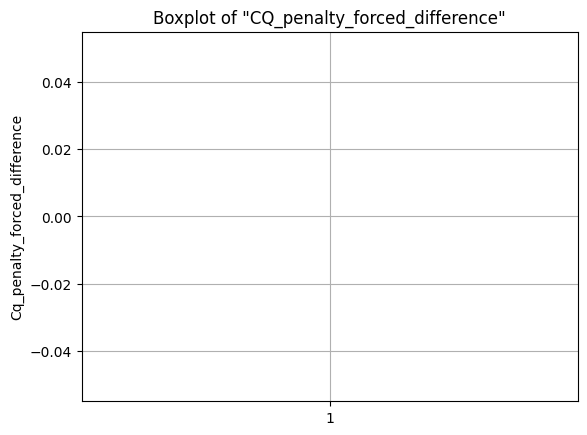

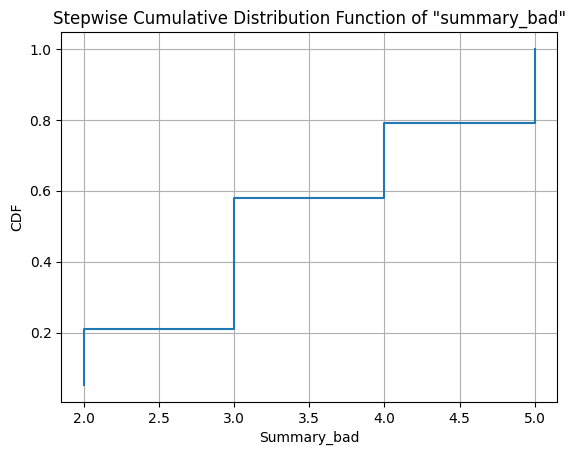

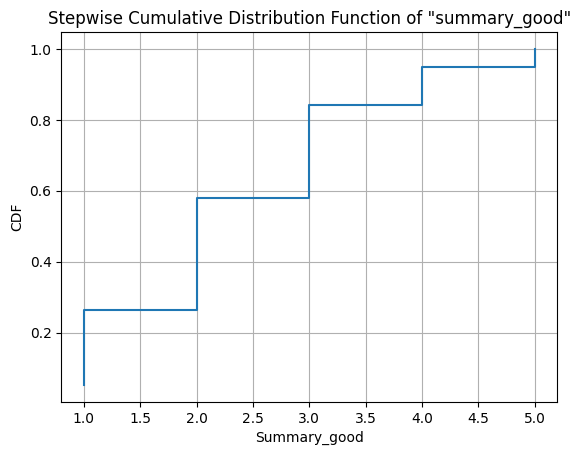

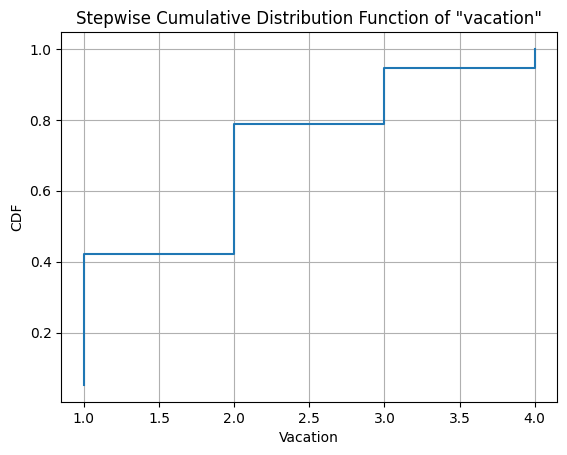

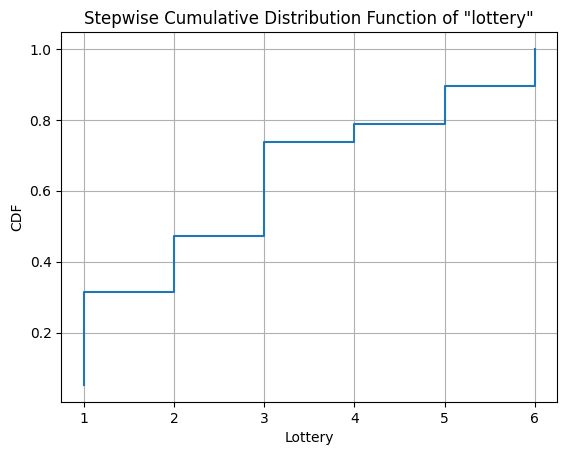

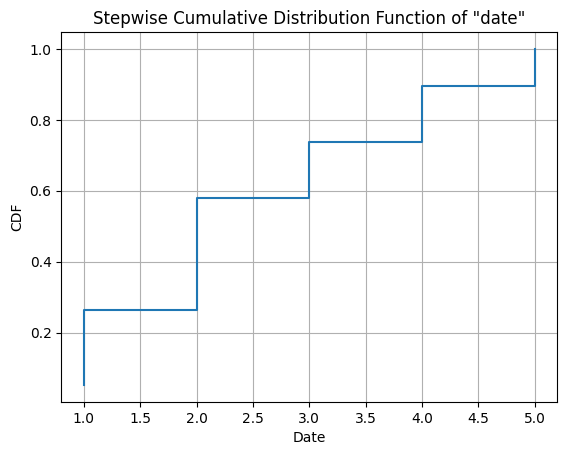

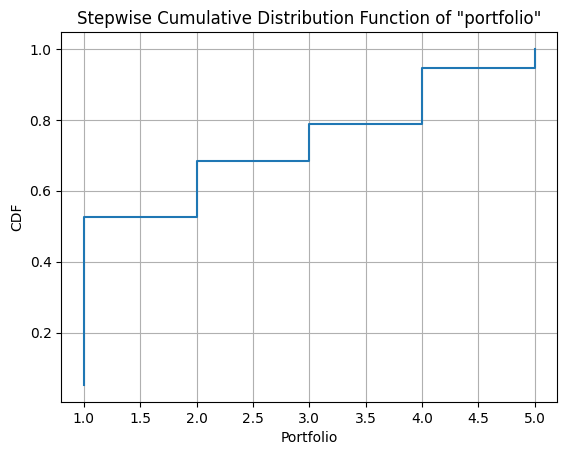

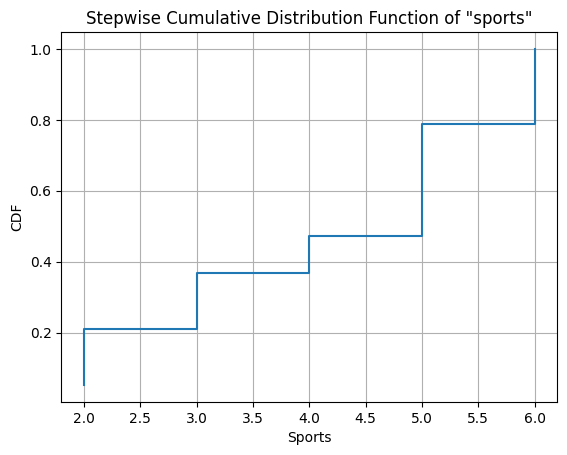

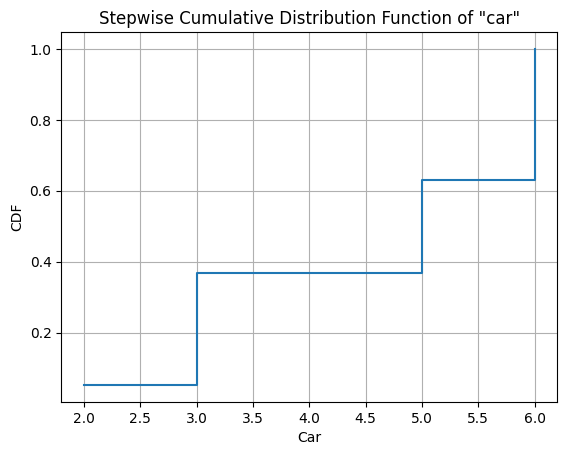

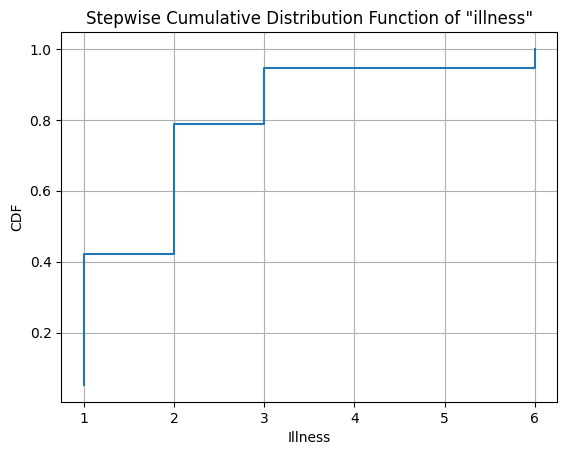

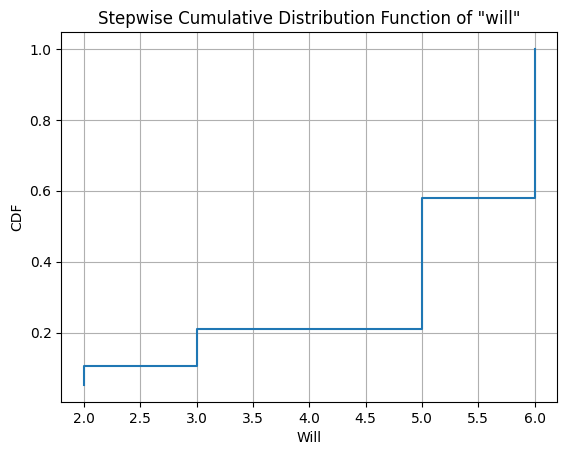

In [68]:
def plot_and_save_cdf(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Group the DataFrame by the "treatment" column
        grouped_data = data.groupby('valence')[column_name]

        # Calculate and plot the stepwise CDF for each treatment group
        for treatment, group in grouped_data:
            sorted_data = np.sort(group)
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            ax.step(sorted_data, cdf, where='post', label=treatment)

        # Add legend
        ax.legend()

    else:
        # Calculate and plot the stepwise CDF for the entire dataset
        sorted_data = np.sort(data[column_name])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.step(sorted_data, cdf, where='post')

    # Add labels and title
    ax.set_xlabel(column_name.capitalize())
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise Cumulative Distribution Function of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_boxplot(data, column_name, subfolder_name, by_treatment=True):
    # Create a figure and axis
    fig, ax = plt.subplots()

    if by_treatment:
        # Data for boxplot
        treatment_values = data['valence'].unique()
        data_to_plot = [data[data['valence'] == treatment][column_name] for treatment in treatment_values]

        # Create the boxplots
        ax.boxplot(data_to_plot, labels=treatment_values)

    else:
        # Data for boxplot
        data_to_plot = data[column_name]

        # Create the boxplot
        ax.boxplot(data_to_plot)

    # Add labels and title
    ax.set_ylabel(column_name.capitalize())
    ax.set_title(f'Boxplot of "{column_name}"')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'boxplot_{column_name}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Call the function to plot and save the CDF for 'emotionsPart1'
plot_and_save_cdf(data, 'emotionsPart1', subfolder_name)


# Call the function to plot and save the CDF for 'num_draws'
plot_and_save_cdf(data, 'num_draws', subfolder_name)

# Call the function to plot and save the CDF for 'payoff'
plot_and_save_cdf(data, 'payoff', subfolder_name)

# Call the function to plot and save the CDF for 'mistakes_total'
plot_and_save_cdf(data, 'mistakes_total', subfolder_name)

# Call the function to plot and save the boxplot for 'num_draws'
plot_and_save_boxplot(data, 'num_draws', subfolder_name)

# Call the function to plot and save the boxplot for 'payoff'
plot_and_save_boxplot(data, 'payoff', subfolder_name)

# Call the function to plot and save the boxplot for 'mistakes_total'
plot_and_save_boxplot(data, 'mistakes_total', subfolder_name)


# Call the function to plot and save the CDF for 'wtp_point'
plot_and_save_cdf(data, 'wtp_point', subfolder_name)


# Call the function to plot and save the boxplot for 'wtp_point'
plot_and_save_boxplot(data, 'wtp_point', subfolder_name)


# Call the function to plot and save the CDF for 'study_duration'
plot_and_save_cdf(data, 'study_duration_minutes', subfolder_name, by_treatment=False)


# Call the function to plot and save the CDF for 'study_duration'
plot_and_save_cdf(data, 'study_duration_minutes', subfolder_name)


# Call the function to plot and save the boxplot for 'study_duration'
plot_and_save_boxplot(data, 'study_duration_minutes', subfolder_name, by_treatment=False)


# Call the function to plot and save the CDF for 'confused_binary'
plot_and_save_cdf(data, 'confused_binary', subfolder_name, by_treatment=False)


# Call the function to plot and save the boxplot for 'confused_binary'
plot_and_save_boxplot(data, 'confused_binary', subfolder_name, by_treatment=False)


for question in all_questions:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, question, subfolder_name, by_treatment=False)

    # Call the function to plot and save the boxplot for question
    plot_and_save_boxplot(data, question, subfolder_name, by_treatment=False)


unincentivized_questions = ['summary_bad','summary_good'] + ['vacation','lottery','date','portfolio'] + ['sports','car', 'illness','will']

for question in unincentivized_questions:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, question, subfolder_name, by_treatment=False)


In [47]:
data['wtp_point']

0     1.0
1     4.5
2     3.5
3    -5.0
4     3.5
5     6.5
7     6.5
8     1.0
9     4.5
10    3.5
11    3.5
12    3.5
13    2.5
14    3.5
15    3.5
16    3.5
17    4.5
18    7.5
19    3.5
Name: wtp_point, dtype: float64

In [48]:
data['actual_data'][0]

{'num_draws': 6,
 'open_page': 'page1',
 'tentative_bonus': '4.09',
 'tentative_bonus_sequence': ['4.09', '4.09', '4.09', '4.09', '4.09', '4.09']}

In [49]:
data['summary'] = data['summary_bad'] + data['summary_good']

median = data['summary'].median()

data[data['summary']<=median-1].groupby('valence')['wtp_point'].mean()  


valence
bonus      3.333333
penalty    4.100000
Name: wtp_point, dtype: float64

In [71]:
data[['optimal_choice','max_bonus_possible']]

,optimal_choice,max_bonus_possible
0,"[True, True, True, True, True, True]",True
1,"[True, True, True, True, True, True, True, Tru...",True
2,"[True, True, True, True, True, True, True, Tru...",True
3,"[True, True, True, True, True, True, True, Tru...",True
4,"[True, True, True, True, True]",True
5,"[True, True, True]",True
7,"[True, False, True, True, True, False, True, F...",True
8,"[False, True, True, True, True, True, True, Tr...",True
9,"[True, True, True, True, True, True, True, Tru...",True
10,"[True, True, False, False, False, True, True, ...",True
